In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.sparse import csr_matrix, hstack, coo_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# [Cоревнование](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle "Catch Me If You Can"

**Описание задачи:** Будем решать задачу идентификации взломщика по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

В этом соревновании будем решать похожую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.

**Целевая метрика** – ROC AUC. 

**Считаем данные соревнования в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [2]:
PATH_TO_DATA = '/home/kris/Документы/user_identification/week5'

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [5]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

Добавим признаки:
- session_timespan - продолжительность сессии;
- unique_sites – число уникальных сайтов в сессии;
- start_hour – час начала сессии;
- day_of_week – день недели;
- start_month - месяц начала сессии;

In [7]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

In [7]:
train_df[sites] = train_df[sites].fillna(0).astype('int')
train_df[times] = train_df[times].apply(pd.to_datetime)

# Анализ признаков

**1. Добавим признак session_timespan (продолжительность сессии).**

In [8]:
train_df['session_timespan'] = (train_df[times].max(axis=1) - train_df[times].min(axis=1)).dt.seconds

**Посмотрим на продолжительность сессии Элис и остальных пользователей. Ограничим по x значением 100, чтобы не оставлять большой хвост.**

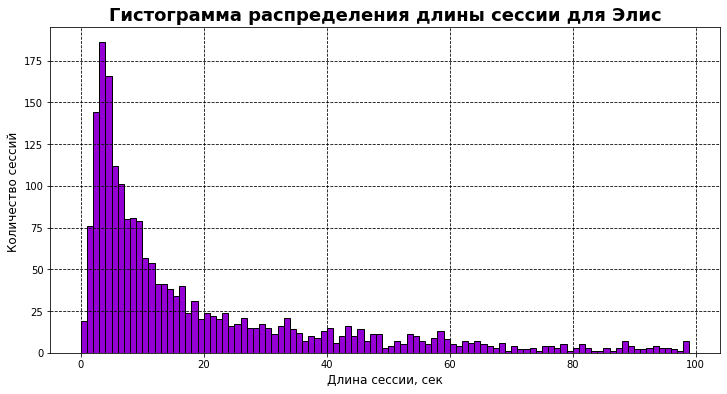

In [9]:
session_timespan_alice = train_df[(train_df['target'] == 1)]['session_timespan']
plt.figure(figsize = (12, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(session_timespan_alice, color='darkviolet', edgecolor = 'black', bins=range(0,100))
plt.title('Гистограмма распределения длины сессии для Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('Длина сессии, сек', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

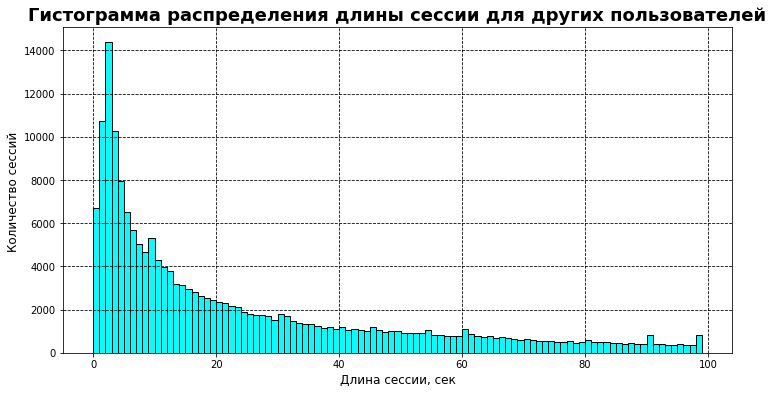

In [10]:
session_timespan = train_df[(train_df['target'] == 0)]['session_timespan']
plt.figure(figsize = (12, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(session_timespan, color='aqua', edgecolor = 'black', bins=range(0,100))
plt.title('Гистограмма распределения длины сессии для других пользователей',fontsize = 18, fontweight = 'bold')
plt.xlabel('Длина сессии, сек', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

Распределение длины сессии Элис повторяет распределение остальных пользователей. Думаю, этот признак не особо нам поможет определить данного пользователя. 

**2. Добавим признак unique_sites (число уникальных сайтов в сессии).**

In [11]:
unique_sites = []
for string in train_df[sites].values:
    if 0 in string:
        unique_sites.append(len(np.unique(string)) - 1)
    else:
        unique_sites.append(len(np.unique(string)))
train_df['unique_sites'] = unique_sites

**Построим гистограммы распределений числа уникальных сайтов для Элис и для других пользователей.**

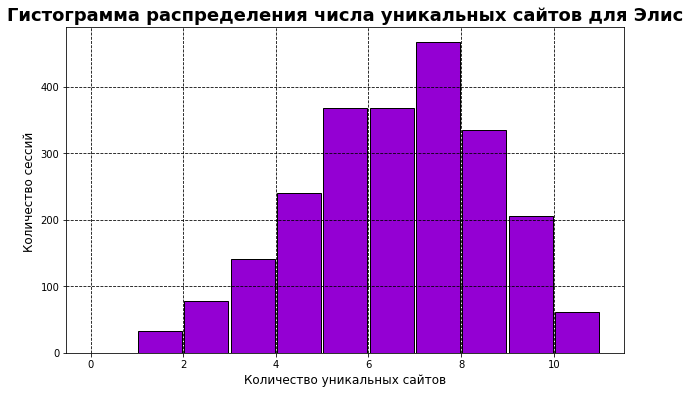

In [12]:
unique_sites_alice = train_df[(train_df['target'] == 1)]['unique_sites']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(unique_sites_alice, color='darkviolet', edgecolor = 'black', bins=range(0,12), rwidth = 0.95)
plt.title('Гистограмма распределения числа уникальных сайтов для Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество уникальных сайтов', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

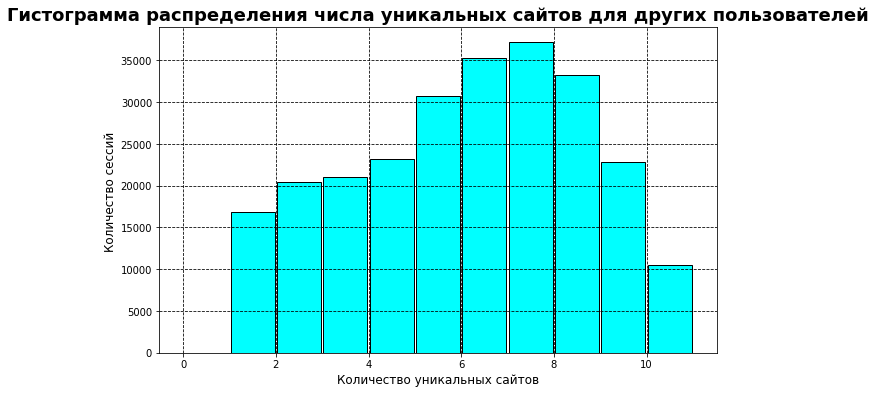

In [13]:
unique_sites = train_df[(train_df['target'] == 0)]['unique_sites']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(unique_sites, color='aqua', edgecolor = 'black', bins=range(0,12), rwidth = 0.95)
plt.title('Гистограмма распределения числа уникальных сайтов для других пользователей',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество уникальных сайтов', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

In [14]:
print('Медианное значение числа уникальных сайтов для Элис: %s' % train_df[(train_df['target'] == 1)]['unique_sites'].median())
print('Медианное значение числа уникальных сайтов для остальных пользователей: %s' % train_df[(train_df['target'] == 0)]['unique_sites'].median())

Медианное значение числа уникальных сайтов для Элис: 6.0
Медианное значение числа уникальных сайтов для остальных пользователей: 6.0


Этот признак тоже не особо может нам помочь вычислить Элис. Посмотрим на остальные.

**3. Добавим признак start_hour (час начала сессии)**

In [15]:
train_df['start_hour'] = (train_df['time1']).dt.hour

**Построим гистограммы распределений часа начала сессий для Элис и для других пользователей.**

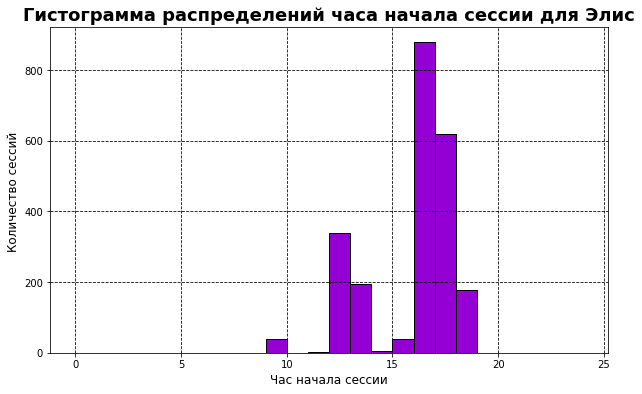

In [16]:
start_hour_alice = train_df[(train_df['target'] == 1)]['start_hour']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(start_hour_alice, color='darkviolet', edgecolor = 'black', bins=range(0,25))
plt.title('Гистограмма распределений часа начала сессии для Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('Час начала сессии', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

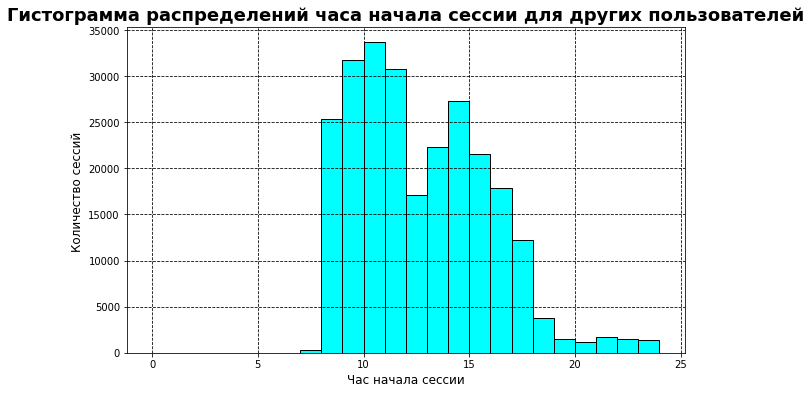

In [17]:
start_hour = train_df[(train_df['target'] == 0)]['start_hour']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(start_hour, color='aqua', edgecolor = 'black', bins=range(0,25))
plt.title('Гистограмма распределений часа начала сессии для других пользователей',fontsize = 18, fontweight = 'bold')
plt.xlabel('Час начала сессии', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

Видим, что распределения существенно отличаются друг от друга. Можно использовать данный признак для идентификации пользователя. На основе этого признака создадим новый times_of_day(время суток). Далее обучим модель отдельно с признаком start_hour и отдельно с times_of_day и посмотрим, где будет качество выше(поскольку эти признаки коррелируют применять вместе их нельзя, так как это ухудшит качество модели) 

In [18]:
times_of_day = []
for hour in train_df.start_hour:
    if hour >= 6 and hour <= 9:
        times_of_day.append(1)
    elif hour > 9 and hour <= 12:
        times_of_day.append(2)
    elif hour > 12 and hour <= 15:
        times_of_day.append(3)
    elif hour > 15 and hour <= 18:
        times_of_day.append(4)
    elif hour > 18 and hour <= 22:
        times_of_day.append(5)
    else:
        times_of_day.append(6)
train_df['times_of_day'] = times_of_day

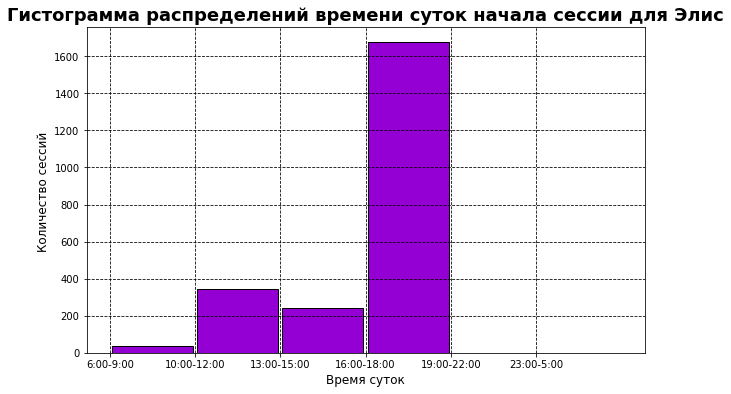

In [19]:
times_of_day_alice = train_df[(train_df['target'] == 1)]['times_of_day']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(times_of_day_alice, color='darkviolet', edgecolor = 'black', bins=range(1,8), rwidth = 0.95)
plt.title('Гистограмма распределений времени суток начала сессии для Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('Время суток', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.xticks(list(range(1,7)),['6:00-9:00', '10:00-12:00', '13:00-15:00', '16:00-18:00', '19:00-22:00', '23:00-5:00'])
plt.show()

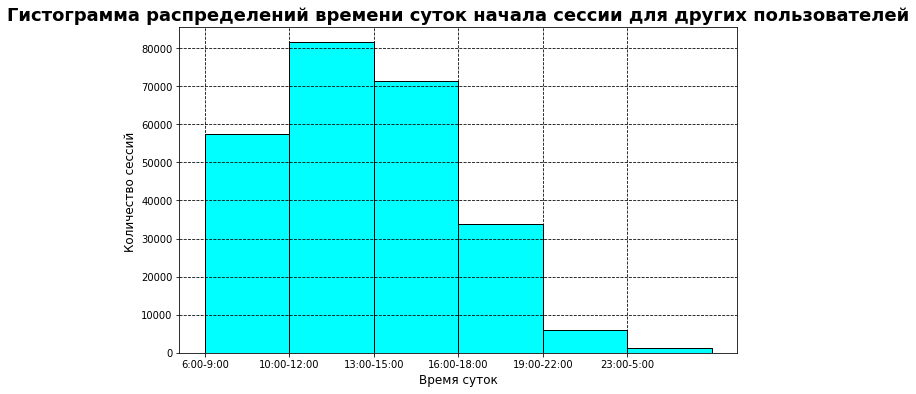

In [20]:
times_of_day = train_df[(train_df['target'] == 0)]['times_of_day']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(times_of_day, color='aqua', edgecolor = 'black', bins=range(1,8))
plt.title('Гистограмма распределений времени суток начала сессии для других пользователей',fontsize = 18, fontweight = 'bold')
plt.xlabel('Время суток', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.xticks(list(range(1,7)),['6:00-9:00', '10:00-12:00', '13:00-15:00', '16:00-18:00', '19:00-22:00', '23:00-5:00'])
plt.show()

Видим, что Элис наиболее активна на интервале между 16:00 и 19:00, в то время как активность других пользователей в основном приходится на обеденное время. 

**4. Добавим признак day_of_week (день недели)**

In [21]:
train_df['day_of_week'] = (train_df['time1']).dt.dayofweek

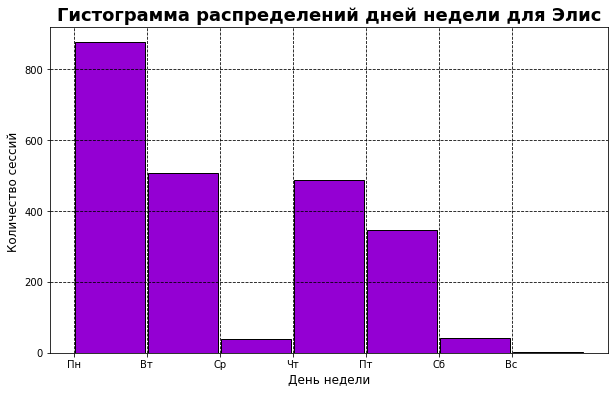

In [22]:
day_of_week_alice = train_df[(train_df['target'] == 1)]['day_of_week']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(day_of_week_alice, color='darkviolet', edgecolor = 'black', bins=range(0, 8), rwidth = 0.95)
plt.title('Гистограмма распределений дней недели для Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('День недели', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.xticks(list(range(0,7)),['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

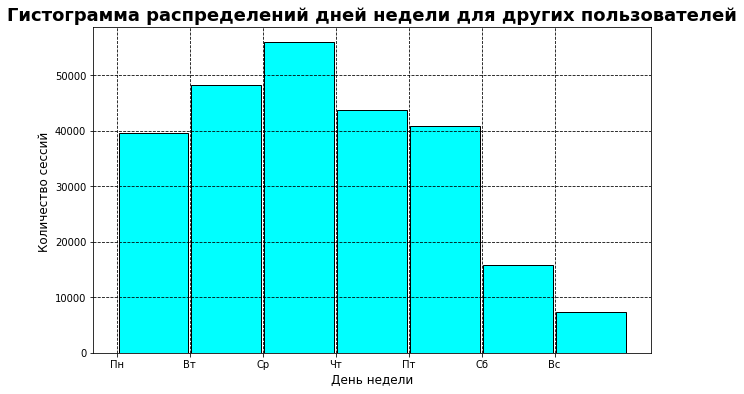

In [23]:
day_of_week = train_df[(train_df['target'] == 0)]['day_of_week']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(day_of_week, color='aqua', edgecolor = 'black', bins=range(0, 8), rwidth = 0.95)
plt.title('Гистограмма распределений дней недели для других пользователей',fontsize = 18, fontweight = 'bold')
plt.xlabel('День недели', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.xticks(list(range(0,7)),['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

Элис бывает активна по будням, кроме среды, в то время как пик активности других пользователей приходится как раз на среду. У Элис он в понедельник. Этот признак поможет нам идентифицировать Элис.

**5. Добавим признак start_month (месяц начала сессии)**

In [24]:
train_df['start_month'] = (train_df['time1']).dt.month

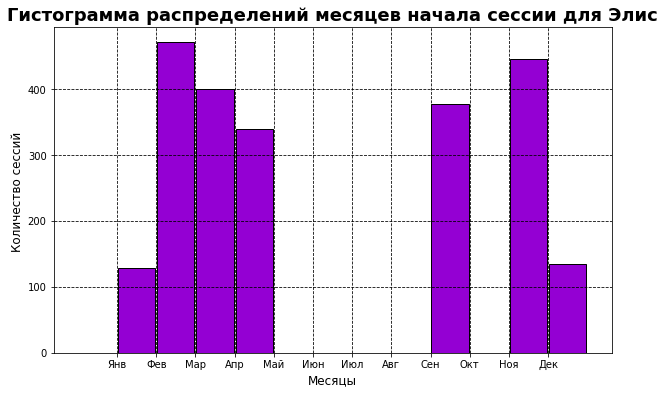

In [25]:
start_month_alice = train_df[(train_df['target'] == 1)]['start_month']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(start_month_alice, color='darkviolet', edgecolor = 'black', bins=range(0, 14), rwidth = 0.95)
plt.title('Гистограмма распределений месяцев начала сессии для Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('Месяцы', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.xticks(list(range(1,13)),['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.show()

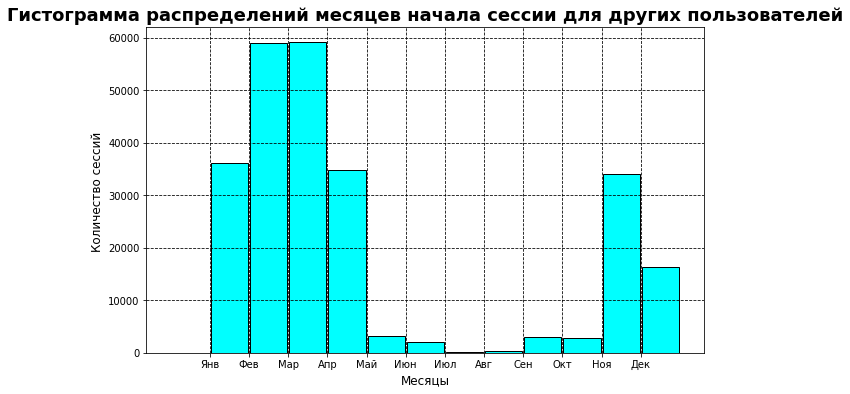

In [26]:
start_month = train_df[(train_df['target'] == 0)]['start_month']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(start_month, color='aqua', edgecolor = 'black', bins=range(0, 14), rwidth = 0.95)
plt.title('Гистограмма распределений месяцев начала сессии для других пользователей',fontsize = 18, fontweight = 'bold')
plt.xlabel('Месяцы', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.xticks(list(range(1,13)),['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.show()

Распределения друг от друга довольно сильно отличаются. Можем использовать этот признак для идентификации Элис.

**6. Добавим признак times_of_year (времена года)**

In [27]:
times_of_year = []
for month in train_df.start_month:
    if month == 12 or month <= 2:
        times_of_year.append(1)
    if month > 2 and month <= 5:
        times_of_year.append(2)
    if month > 5 and month <= 8:
        times_of_year.append(3)
    if month > 8 and month <= 11:
        times_of_year.append(4)
train_df['times_of_year'] = times_of_year

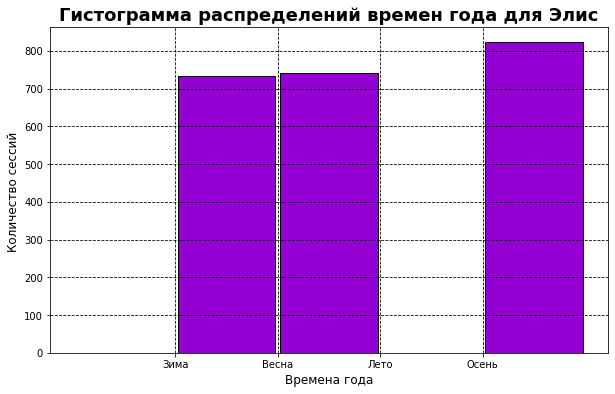

In [28]:
times_of_year_alice = train_df[(train_df['target'] == 1)]['times_of_year']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(times_of_year_alice, color='darkviolet', edgecolor = 'black', bins=range(0, 6), rwidth = 0.95)
plt.title('Гистограмма распределений времен года для Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('Времена года', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.xticks(list(range(1,5)),['Зима', 'Весна', 'Лето', 'Осень'])
plt.show()

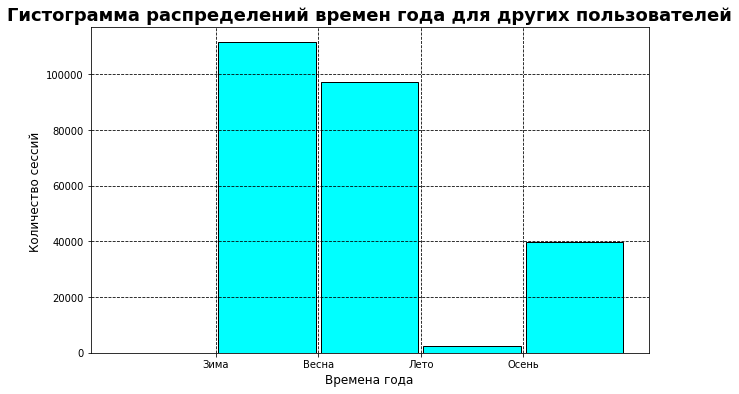

In [29]:
times_of_year = train_df[(train_df['target'] == 0)]['times_of_year']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(times_of_year, color='aqua', edgecolor = 'black', bins=range(0, 6), rwidth = 0.95)
plt.title('Гистограмма распределений времен года для других пользователей',fontsize = 18, fontweight = 'bold')
plt.xlabel('Времена года', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.xticks(list(range(1,5)),['Зима', 'Весна', 'Лето', 'Осень'])
plt.show()

Наблюдаем, что в основном пользователи активны зимой и весной, в то время как Элис активна, и зимой, и весной и осенью. На осень приходится пик активности (с незначительным отрывом от зимы и весны). Любопытный признак. Можем попробовать обучить модель сначала с признаком start_month, а потом отдельно с признаком times_of_year и сравнить результаты. 

**7. Посмотрим на топ самых популярных сайтов у Алисы.**

In [30]:
import itertools 
from collections import Counter

In [3]:
with open(os.path.join(PATH_TO_DATA,'site_dic.pkl'), 'rb') as fp:
    site_dict = pickle.load(fp)

In [32]:
site_dict_rev = dict(zip(site_dict.values(), site_dict.keys()))
alica_sites = train_df[(train_df['target'] == 1)][sites].values
alica_freq_dict = Counter(i for i in list(itertools.chain.from_iterable(alica_sites)))

for i in alica_freq_dict:
    if i in site_dict_rev:
        alica_freq_dict[site_dict_rev[i]] = alica_freq_dict.pop(i)

In [33]:
top20_sites = np.array(alica_freq_dict.most_common(20))[:, 0]
top20_freqs = np.array(alica_freq_dict.most_common(20))[:, 1]

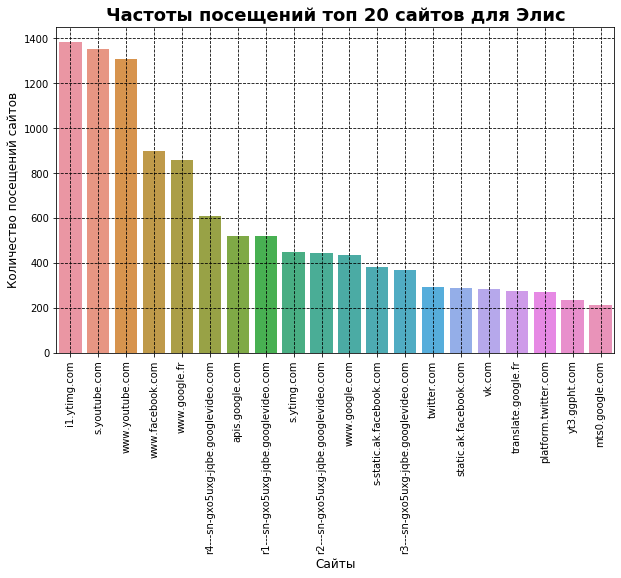

In [34]:
plt.figure(figsize = (10, 6))
sns.barplot(top20_sites, top20_freqs)
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.xticks(rotation=90)
plt.title('Частоты посещений топ 20 сайтов для Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('Сайты', fontsize = 12)
plt.ylabel('Количество посещений сайтов', fontsize = 12)
plt.show()

На гистограмме видно, что наш пользователь любит проводить время в интернете в основном в социальных сетях. 
Построим признаки: количество посещений youtube, facebook, google, twitter, vk за сессию.

In [35]:
train_df['yt_visit'] = (train_df[sites].isin([site_dict[key] for key in site_dict if 'youtube' in key or 'ytimg' in key])).sum(1)
train_df['fb_visit'] = (train_df[sites].isin([site_dict[key] for key in site_dict if 'facebook' in key])).sum(1)
train_df['google_visit'] = (train_df[sites].isin([site_dict[key] for key in site_dict if 'google' in key])).sum(1)
train_df['tw_visit'] = (train_df[sites].isin([site_dict[key] for key in site_dict if 'twitter' in key])).sum(1)
train_df['vk_visit'] = (train_df[sites].isin([site_dict[key] for key in site_dict if 'vk' in key])).sum(1)

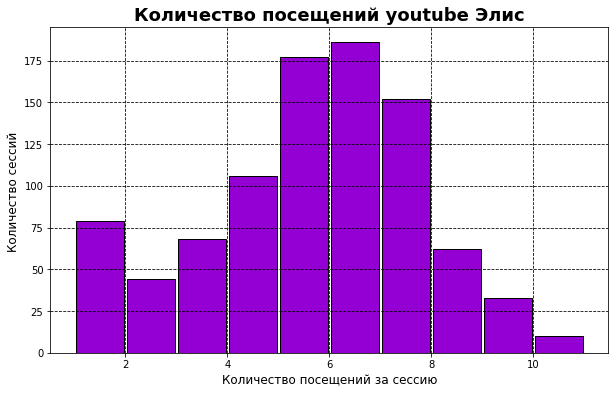

In [36]:
yt_visit_alice = train_df[(train_df['target'] == 1)]['yt_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(yt_visit_alice, color='darkviolet', edgecolor = 'black', bins=range(1,12), rwidth = 0.95)
plt.title('Количество посещений youtube Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

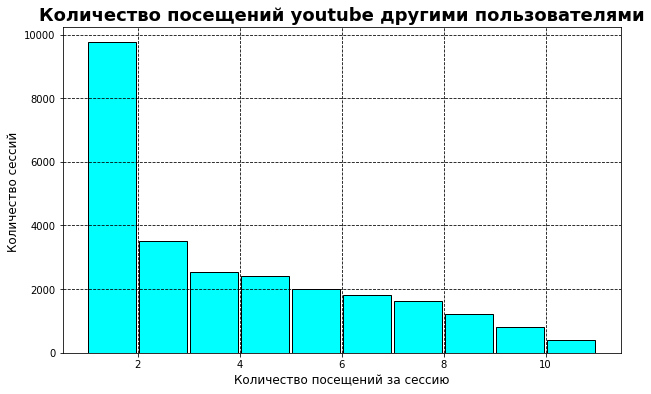

In [37]:
yt_visit = train_df[(train_df['target'] == 0)]['yt_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(yt_visit, color='aqua', edgecolor = 'black', bins=range(1,12), rwidth = 0.95)
plt.title('Количество посещений youtube другими пользователями',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

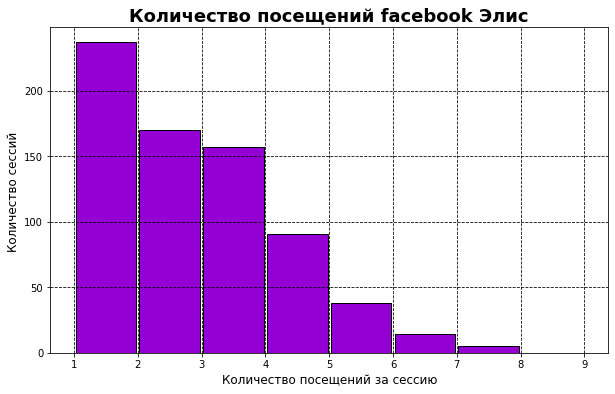

In [38]:
fb_visit_alice = train_df[(train_df['target'] == 1)]['fb_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(fb_visit_alice, color='darkviolet', edgecolor = 'black', bins=range(1,10), rwidth = 0.95)
plt.title('Количество посещений facebook Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

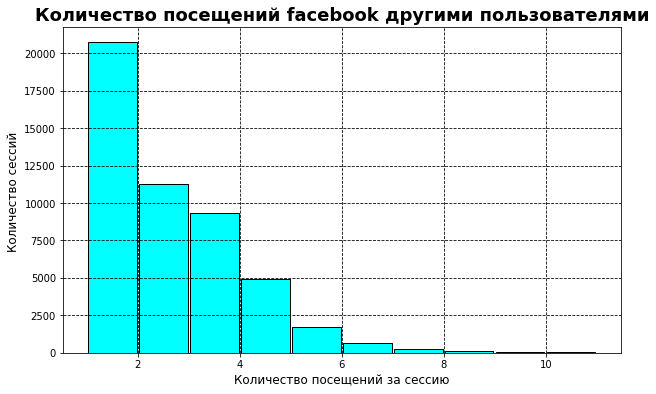

In [39]:
fb_visit = train_df[(train_df['target'] == 0)]['fb_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(fb_visit, color='aqua', edgecolor = 'black', bins=range(1,12), rwidth = 0.95)
plt.title('Количество посещений facebook другими пользователями',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

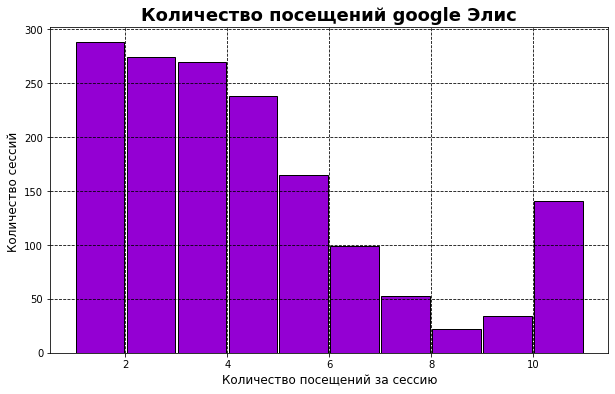

In [40]:
google_visit_alice = train_df[(train_df['target'] == 1)]['google_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(google_visit_alice, color='darkviolet', edgecolor = 'black', bins=range(1,12), rwidth = 0.95)
plt.title('Количество посещений google Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

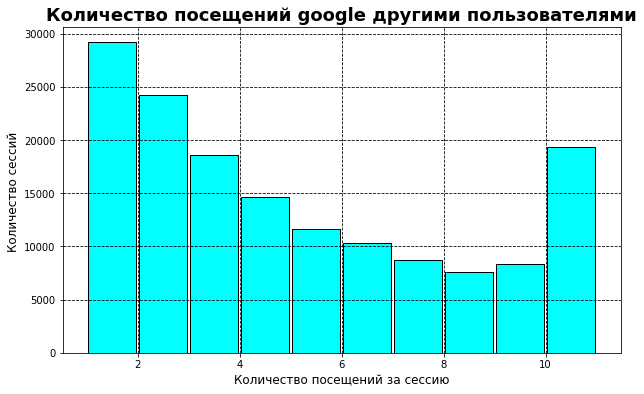

In [41]:
google_visit = train_df[(train_df['target'] == 0)]['google_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(google_visit, color='aqua', edgecolor = 'black', bins=range(1,12), rwidth = 0.95)
plt.title('Количество посещений google другими пользователями',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

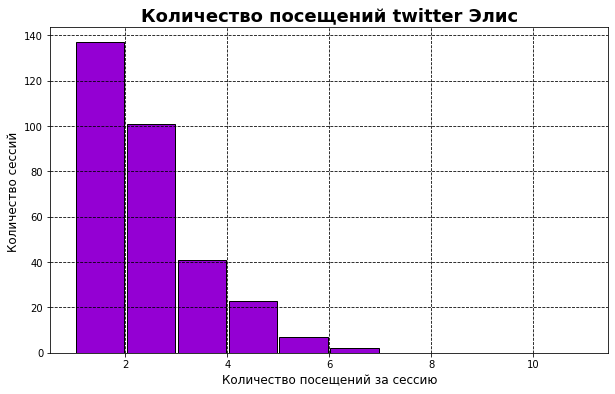

In [42]:
tw_visit_alice = train_df[(train_df['target'] == 1)]['tw_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(tw_visit_alice, color='darkviolet', edgecolor = 'black', bins=range(1,12), rwidth = 0.95)
plt.title('Количество посещений twitter Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

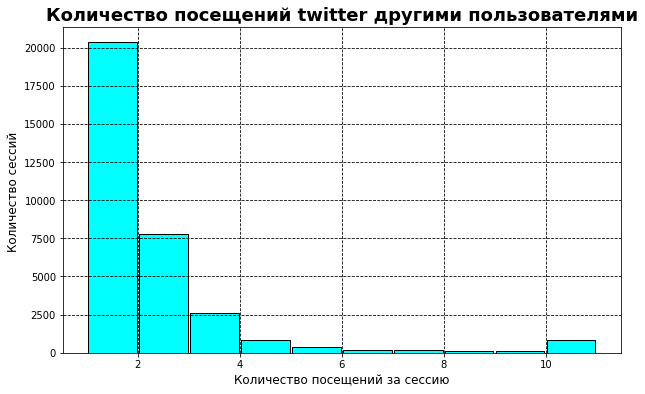

In [43]:
tw_visit = train_df[(train_df['target'] == 0)]['tw_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(tw_visit, color='aqua', edgecolor = 'black', bins=range(1,12), rwidth = 0.95)
plt.title('Количество посещений twitter другими пользователями',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

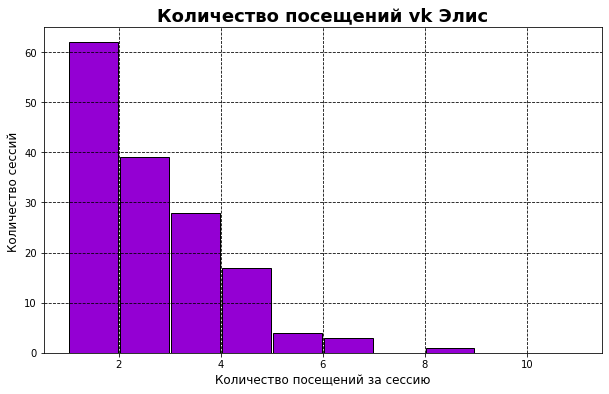

In [44]:
vk_visit_alice = train_df[(train_df['target'] == 1)]['vk_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(vk_visit_alice, color='darkviolet', edgecolor = 'black', bins=range(1,12), rwidth = 0.95)
plt.title('Количество посещений vk Элис',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

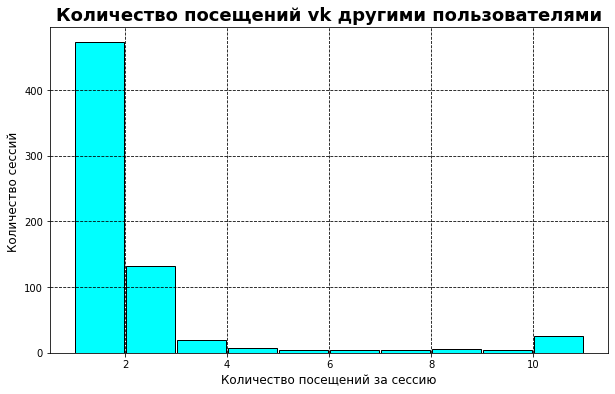

In [45]:
vk_visit = train_df[(train_df['target'] == 0)]['vk_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(vk_visit, color='aqua', edgecolor = 'black', bins=range(1,12), rwidth = 0.95)
plt.title('Количество посещений vk другими пользователями',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

**8. Анализ признаков завершен, пришло время обучить модель. Для этого снова загрузим обучающую и тестовую выборки.**

In [44]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

**Объединим обучающую и тестовую выборки, чтоб вместе потом привести их к разреженному формату.**

In [45]:
train_test_df = pd.concat([train_df, test_df])

In [46]:
train_test_df_sites = train_test_df[sites].fillna(0).astype('int')
train_test_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178


**Создадим разреженную матрицу**

In [47]:
train_test_sparse_sites = csr_matrix((np.ones(train_test_df_sites.values.size, dtype=np.uint8),
                          train_test_df_sites.values.reshape(-1),
                          np.arange(train_test_df_sites.values.shape[0] + 1) * train_test_df_sites.values.shape[1]))[:, 1:]

**Были отобраны следующие признаки, комбинация которых показала наивысший результат на тестовой выборке:**
- start_hour;
- day_of_week;
- times_of_year;
- yt_visit;
- vk_visit;
- fb-visit;
- tw-visit;

In [48]:
train_test_df['start_hour'] = pd.to_datetime(train_test_df['time1']).dt.hour
train_test_df['day_of_week'] = pd.to_datetime(train_test_df['time1']).dt.dayofweek
train_test_df['start_month'] = pd.to_datetime(train_test_df['time1']).dt.month

In [49]:
train_test_df['yt_visit'] = (train_test_df[sites].isin([site_dict[key] for key in site_dict if 'youtube' in key or 'ytimg' in key])).sum(1)
train_test_df['vk_visit'] = (train_test_df[sites].isin([site_dict[key] for key in site_dict if 'vk' in key])).sum(1)
train_test_df['fb_visit'] = (train_test_df[sites].isin([site_dict[key] for key in site_dict if 'facebook' in key])).sum(1)
train_test_df['tw_visit'] = (train_test_df[sites].isin([site_dict[key] for key in site_dict if 'twitter' in key])).sum(1)

In [50]:
times_of_year = []
for month in train_test_df.start_month:
    if month == 12 or month <= 2:
        times_of_year.append(1)
    if month > 2 and month <= 5:
        times_of_year.append(2)
    if month > 5 and month <= 8:
        times_of_year.append(3)
    if month > 8 and month <= 11:
        times_of_year.append(4)
train_test_df['times_of_year'] = times_of_year

**Так как признаки day_of_week, start_hour, times_of_year категориальные, необходимо осуществить их векторизацию.**

In [51]:
train_test_df = pd.get_dummies(train_test_df, columns = ['day_of_week', 'start_hour', 'times_of_year'])

In [52]:
features = train_test_df.iloc[:, 22:]

**Объединим ранее полученную разреженную матрицу с векторизированными признаками, а потом разобъем на обучающую и тестовую выборки.**

In [53]:
from scipy.sparse import csr_matrix, hstack, coo_matrix

In [55]:
X_big_train_test = csr_matrix(hstack([train_test_sparse_sites, csr_matrix(features)]))
X_big_train = X_big_train_test[:253561, :]
X_test = X_big_train_test[253561:, :]
y = train_df['target'].values

**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [56]:
train_share = int(.7 * X_big_train.shape[0])
X_train, y_train = X_big_train[:train_share, :], y[:train_share]
X_valid, y_valid  = X_big_train[train_share:, :], y[train_share:]

**Сделаем прогноз на отложенной выборке**

In [57]:
sgd_logit = SGDClassifier(loss='log', random_state=17, max_iter=500, alpha=1e-06, n_iter_no_change=4)
sgd_logit.fit(X_train, y_train)
sgd_logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)[:, 1]
round(roc_auc_score(y_valid, sgd_logit_valid_pred_proba), 5)

0.9844

**Теперь сделаем прогноз уже на тестовой выборке**

In [58]:
sgd_logit = SGDClassifier(loss='log', random_state=17, max_iter=500, alpha=1e-06, n_iter_no_change=4)
sgd_logit.fit(X_big_train, y)
predict = sgd_logit.predict_proba(X_test)[:, 1]

**Запишем в файл**

In [25]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [59]:
write_to_submission_file(predict, "predictions/sgd.csv")

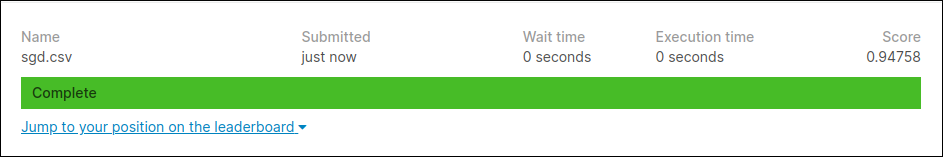

**9. Теперь применим логистическую регрессию**

**Зададим кросс-валидацию**

In [36]:
time_split = TimeSeriesSplit(n_splits=10)

**Для начала обучим логистическую регрессию с параметрами по умолчанию и сделаем прогноз на отложенной выборке**

In [37]:
logit = LogisticRegression(random_state=17)
logit_cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, scoring='roc_auc').mean()
logit.fit(X_train, y_train)
logit_valid_pred_proba = logit.predict_proba(X_valid)[:, 1]

In [38]:
round(roc_auc_score(y_valid, logit_valid_pred_proba), 5)

0.98626

**Теперь обучим уже на всей обучащей выборке**

In [39]:
logit.fit(X_big_train, y)
predict = logit.predict_proba(X_test)[:, 1]

**Запишем в файл и отправим посылку на kaggle**

In [40]:
write_to_submission_file(predict, "predictions/logit.csv")

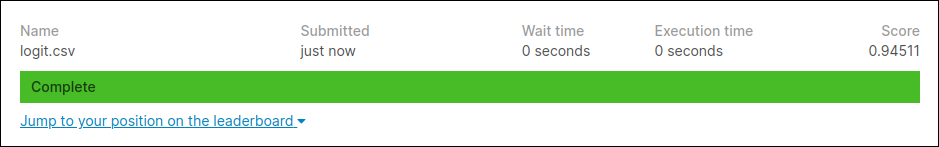

**Значение ROC AUC получилось ниже, чем при применении SGDClassifier. Но для последнего была произведена настройка параметров. Здесь попробуем подобрать параметр C.**

In [30]:
%%time
c_values = np.logspace(-2, 2, 10)
logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)
logit_grid_searcher.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


CPU times: user 15.7 s, sys: 556 ms, total: 16.2 s
Wall time: 1min 13s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
     

In [31]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9819301409694005, {'C': 12.915496650148826})

**Посмотрим на отложенной выборке значение roc_auc при найденном параметре С**

In [43]:
pre = logit_grid_searcher.predict_proba(X_valid)[:, 1]
round(roc_auc_score(y_valid, pre), 5)

0.98798

In [32]:
best_param = 12.915496650148826

**Теперь обучим на всей тренировочной выборке с найденным параметром С и сделаем посылку на kaggle**

In [34]:
logit = LogisticRegression(C=best_param, random_state=17)
logit.fit(X_big_train, y)
predict = logit.predict_proba(X_test)[:, 1]

In [35]:
write_to_submission_file(predict, "predictions/tune_logit.csv")

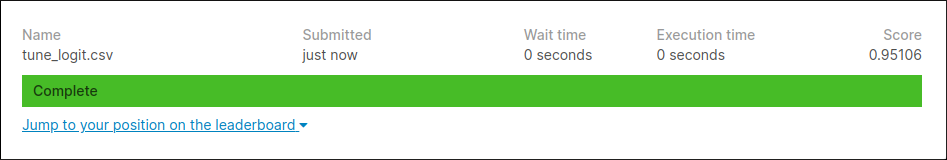

С подобранным параметром C = 12.916 для логистической регрессии удалось получить значение метрики ROC_AUC = 0.95106. Пока что это наивысший результат, который я смогла достичь в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2)  Catch Me If You Can.
Для улучшения результата в дальнейшем можно попробовать добавить новые признаки и продолжить настройку модели. 